In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import re
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from collections import Counter
from wordcloud import WordCloud
from xgboost import XGBClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# 初始化 WordNet 詞形還原器與停用詞
lm = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [6]:
# 讀取 IMDB 電影評論資料集，並隨機取樣 8500 筆樣本
df = pd.read_csv(r"/content/drive/MyDrive/Dataset/IMDB_Dataset.csv")
df = df.sample(8500, random_state=36)

In [7]:
print(df.shape, end='\n\n')
print(df.info())

(8500, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 10854 to 34711
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8500 non-null   object
 1   sentiment  8500 non-null   object
dtypes: object(2)
memory usage: 199.2+ KB
None


In [8]:
# 移除缺失值
df.isnull()
df = df.dropna()

In [9]:
print(df.shape, end='\n\n')
print(df.info())

(8500, 2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8500 entries, 10854 to 34711
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     8500 non-null   object
 1   sentiment  8500 non-null   object
dtypes: object(2)
memory usage: 199.2+ KB
None


In [10]:
print(df.head())

                                                  review sentiment
10854  This is an hybrid creature born at Carl Macek ...  negative
25169  This isn't one of Arbuckle's or Keaton's bette...  negative
25810  James Aaron, a chubby actor living in Chicago,...  positive
13591  I'll admit that I've never seen "Waiting for G...  positive
26717  NATURAL BORN KILLERS (1994)<br /><br />Cinema ...  negative


In [11]:
# 文本預處理函數，將評論轉換為小寫、去除標點符號、標記化、詞形還原等操作
def transform_data(review):
    # 使用BeautifulSoup移除HTML標記
    review = BeautifulSoup(review, "html.parser").get_text()
    # 將文本轉換為小寫
    review = review.lower()
    # 移除非字母字符
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    # 將文本分詞
    tokens = nltk.word_tokenize(review)
    # 進行詞形還原並移除停用詞
    review = [lm.lemmatize(token) for token in tokens if token not in stop_words]
    # 將處理後的單詞組合成一個文本字串
    review = " ".join(review)
    return review

In [12]:
# 將文本資料進行預處理
tranformed_rev = df.review.apply(transform_data)

<ipython-input-11-482c5db4f95b>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, "html.parser").get_text()


In [13]:
print(tranformed_rev.head())

10854    hybrid creature born carl macek mind robotech ...
25169    isnt one arbuckles keaton better film thats su...
25810    james aaron chubby actor living chicago man lo...
13591    ill admit ive never seen waiting guffman criti...
26717    natural born killer cinema cut r director cut ...
Name: review, dtype: object


In [14]:
# 資料視覺化：建立正面和負面情緒的詞雲和詞頻分析
transformed_data = pd.DataFrame({"t_rev": tranformed_rev, "sentiment": df['sentiment']})

In [15]:
print(transformed_data.head())

                                                   t_rev sentiment
10854  hybrid creature born carl macek mind robotech ...  negative
25169  isnt one arbuckles keaton better film thats su...  negative
25810  james aaron chubby actor living chicago man lo...  positive
13591  ill admit ive never seen waiting guffman criti...  positive
26717  natural born killer cinema cut r director cut ...  negative


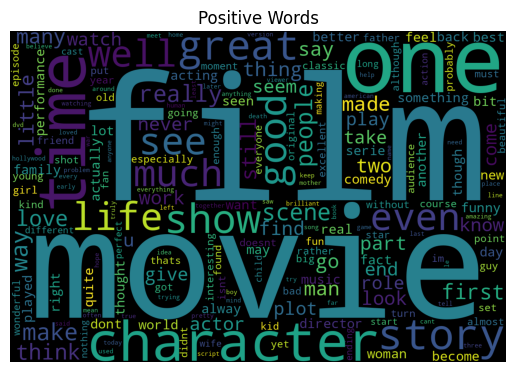

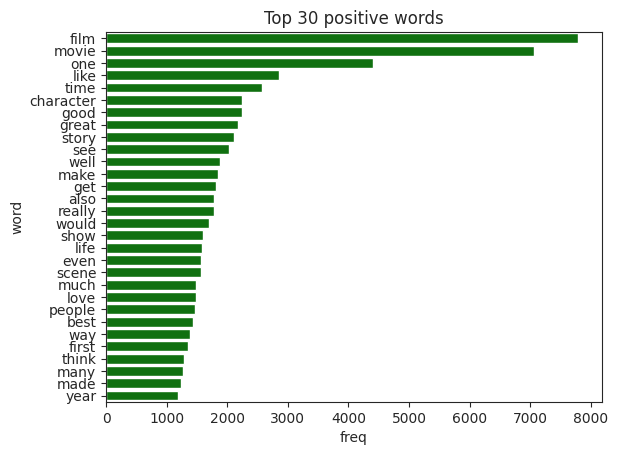

In [16]:
# 正面情緒詞雲及詞頻分析
tokens = str(list(transformed_data[transformed_data.sentiment == 'positive'].t_rev)).split()
pos_words = (" ").join(tokens)
wc = WordCloud(height=800, width=1200).generate(pos_words)
plt.imshow(wc)
plt.title("Positive Words")
plt.axis("off")
plt.show()
positive_words_frequency = Counter(tokens)
ps_f = positive_words_frequency.most_common(30)
data = pd.DataFrame(ps_f, columns=['word', 'freq']).sort_values('freq', ascending=False)
sns.set_style("ticks")
sns.barplot(x="freq", y='word', data=data, color='g').set(title='Top 30 positive words')
plt.show()

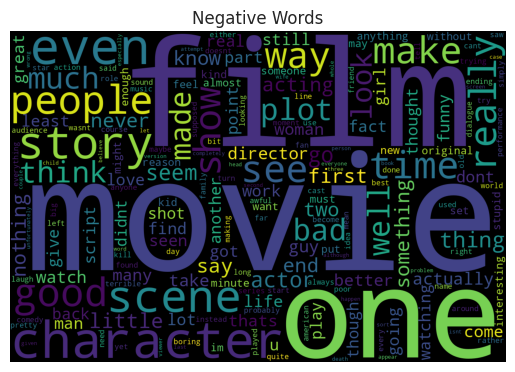

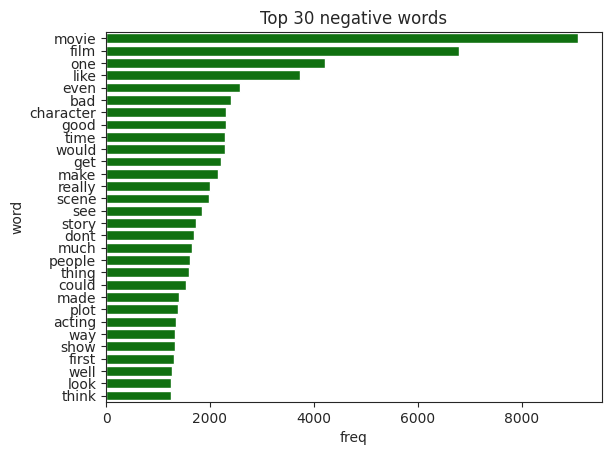

In [17]:
# 負面情緒詞雲及詞頻分析
tokens = str(list(transformed_data[transformed_data.sentiment == 'negative'].t_rev)).split()
neg_words = (" ").join(tokens)
wc = WordCloud(height=800, width=1200).generate(neg_words)
plt.imshow(wc)
plt.title("Negative Words")
plt.axis("off")
plt.show()
negative_words_frequency = Counter(tokens)
neg_f = negative_words_frequency.most_common(30)
data = pd.DataFrame(neg_f, columns=['word', 'freq']).sort_values('freq', ascending=False)
sns.barplot(x="freq", y='word', data=data, color='g').set(title='Top 30 negative words')
plt.show()

In [18]:
# 切分訓練集和測試集
X = tranformed_rev
y = df.sentiment.replace({'positive': 1, 'negative': 0})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
import numpy as np

# 使用 numpy 的 unique 函數來獲取每個類別的數量及其對應的標籤
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

# 轉換為字典格式方便查看
train_distribution = dict(zip(unique_train, counts_train))
test_distribution = dict(zip(unique_test, counts_test))

print('y_train 分布:', train_distribution)
print('y_test 分布:', test_distribution)


y_train 分布: {0: 3387, 1: 3413}
y_test 分布: {0: 847, 1: 853}


In [20]:
# 特徵提取
tf = TfidfVectorizer()
cv = CountVectorizer()
# lb = LabelEncoder()
X_train = tf.fit_transform(X_train).toarray()
X_test = tf.transform(X_test).toarray()

In [21]:
# 模型選擇
models = {
    'lr': LogisticRegression(),
    'rf': RandomForestClassifier(),
    'gs': GaussianNB(),
    'knn': KNeighborsClassifier(),
    'xgb': XGBClassifier()
}

In [24]:
# 訓練多個模型並評估其表現
def fit_predict(models, X_train, y_trian, X_test, y_test):
    y_pred = []
    models_name = []
    for model_name, model_obj in models.items():
        print(f'Training {model_name} .... ')
        model_obj.fit(X_train, y_trian)
        print(f'{model_name} done....')
        y_pred.append(model_obj.predict(X_test))
        models_name.append(model_name)
    return y_pred, models_name

In [23]:
def get_score(y_pred, y_test):
    score = [accuracy_score(y_test, y) for y in y_pred]
    return score

In [25]:
print(X_train.shape)
print(y_train.shape)

y_pred, models_name = fit_predict(models, X_train, y_train, X_test, y_test)

(6800, 58860)
(6800,)
Training lr .... 
lr done....
Training rf .... 
rf done....
Training gs .... 
gs done....
Training knn .... 
knn done....
Training xgb .... 
xgb done....


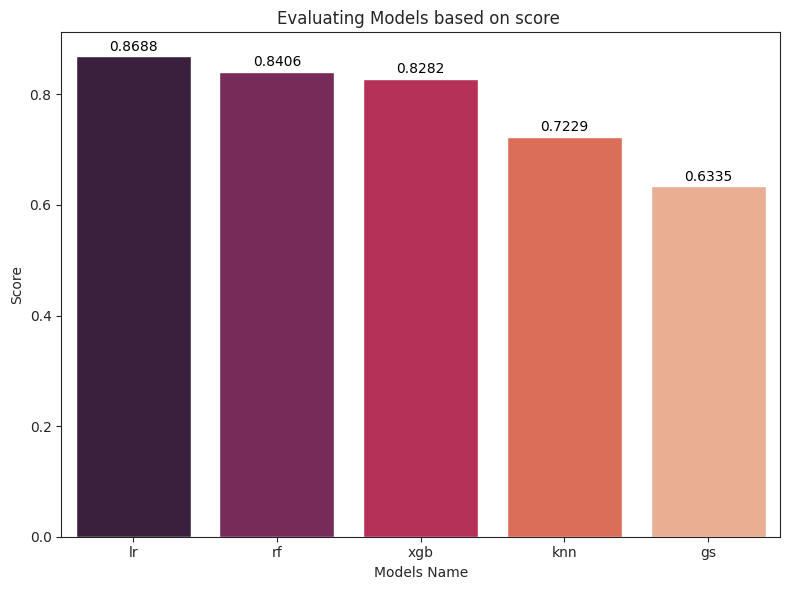

In [26]:
# 計算模型的得分
score = get_score(y_pred, y_test)

# 創建包含模型名稱和分數的 DataFrame
md_scores = pd.DataFrame({'models': models_name, 'score': score})

md_scores_sorted = md_scores.sort_values(by='score', ascending=False)

# 繪製柱狀圖，並將分數顯示在每個柱上
plt.figure(figsize=(8, 6))
bars = sns.barplot(x='models', y='score', data=md_scores_sorted, palette='rocket')

# 在每個柱上顯示分數（從已排序的 DataFrame 中讀取分數資料）
for bar, value in zip(bars.patches, md_scores_sorted['score']):
    bars.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, round(value, 4), ha='center', color='black', fontsize=10)

plt.title('Evaluating Models based on score ')
plt.xlabel('Models Name')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

In [27]:
# 定義繪製混淆矩陣和分類報告的函數
def plot_evaluation_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.show()
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Evaluating Model: lr


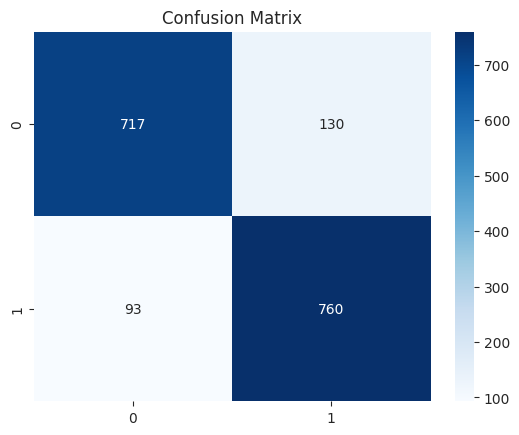

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       847
           1       0.85      0.89      0.87       853

    accuracy                           0.87      1700
   macro avg       0.87      0.87      0.87      1700
weighted avg       0.87      0.87      0.87      1700

Evaluating Model: rf


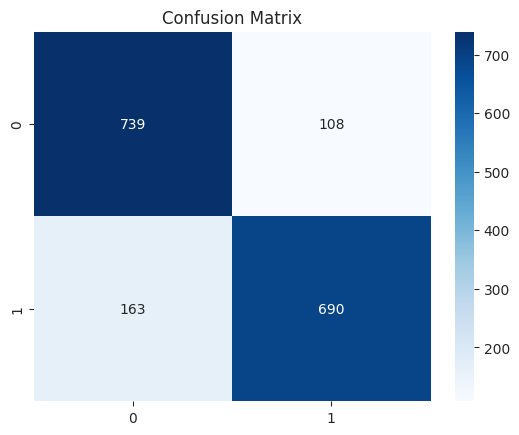

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       847
           1       0.86      0.81      0.84       853

    accuracy                           0.84      1700
   macro avg       0.84      0.84      0.84      1700
weighted avg       0.84      0.84      0.84      1700

Evaluating Model: gs


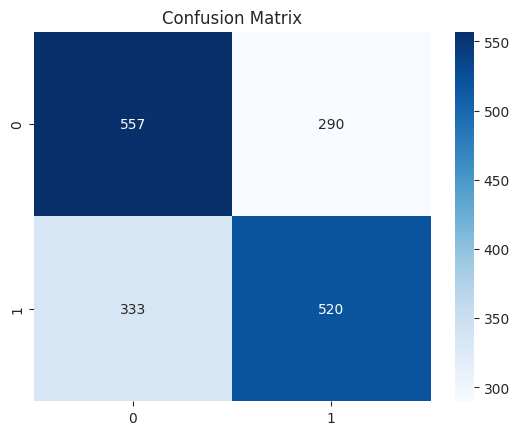

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.64       847
           1       0.64      0.61      0.63       853

    accuracy                           0.63      1700
   macro avg       0.63      0.63      0.63      1700
weighted avg       0.63      0.63      0.63      1700

Evaluating Model: knn


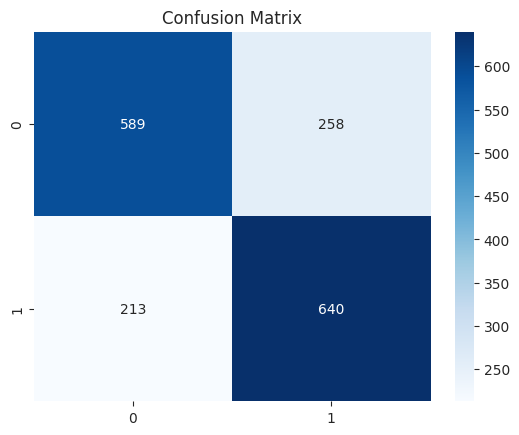

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.70      0.71       847
           1       0.71      0.75      0.73       853

    accuracy                           0.72      1700
   macro avg       0.72      0.72      0.72      1700
weighted avg       0.72      0.72      0.72      1700

Evaluating Model: xgb


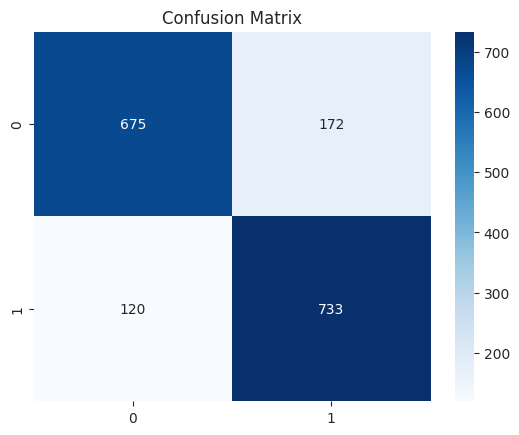

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.82       847
           1       0.81      0.86      0.83       853

    accuracy                           0.83      1700
   macro avg       0.83      0.83      0.83      1700
weighted avg       0.83      0.83      0.83      1700



In [28]:
# 對每個模型進行訓練和評估
for model_name, model_obj in models.items():
    print(f"Evaluating Model: {model_name}")
    plot_evaluation_metrics(model_obj, X_test, y_test)